# Description:  

This notebook uses an artificial recurrent neural network called LSTM (long short term memory) to predict the closing stock price of a corporation (Apple Inc.) using past 60 days stock price.

In [43]:
# imports
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import joblib

Attempt to fetch data from yahoo using __pandas_datareader__

In [44]:
# import pandas_datareader as web

# df = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2022-07-17')

# TypeError: string indices must be integers

Attempt to fetch data from yahoo using __yahoo finance (yfinance) package__

In [45]:
# pip install yfinance
import yfinance as yf

# Fetch stock data for AAPL from Yahoo Finance
df = yf.download('AAPL', start='2012-01-01', end='2022-07-17')

df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.449692,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.516598,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.655556,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.787856,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.767573,394024400


In [46]:
df.shape

(2651, 6)

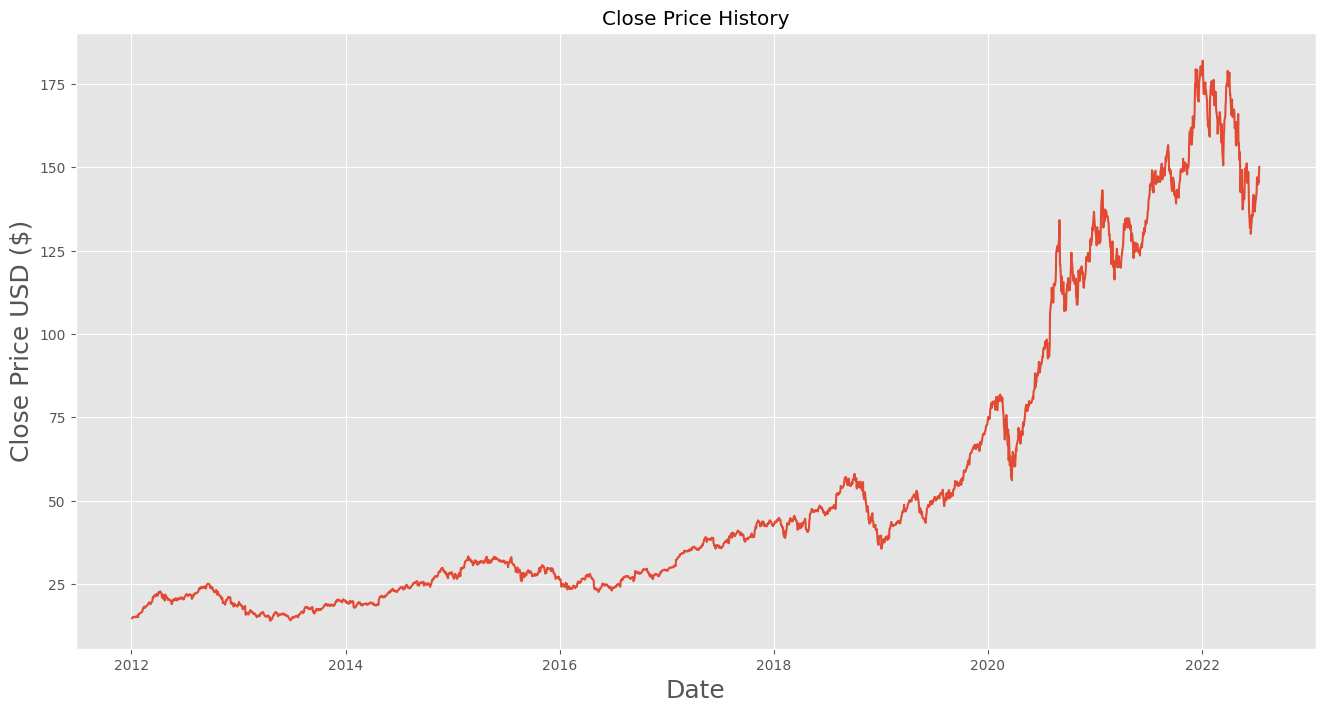

In [47]:
# Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [48]:
# filtering df to have only the 'Close' column
data = df.filter(['Close'])

# Conver the dataframe to a numpy array
dataset = data.values

# Get the number of rows to train the model (80% of dataset)
training_data_len = math.ceil(len(dataset) * 0.8) # math.ceil rounds that up
print(training_data_len)

2121


In [49]:
type(dataset)

numpy.ndarray

## Scaling the dataset with Min Max Scaler

for most cases involving neural networks, including Keras sequential models, it's beneficial to scale your data.

Neural networks, including those built using Keras, often use optimization algorithms like gradient descent to update the weights during training. Scaling the input features can significantly help in this context:

- Convergence Speed: Scaling the features to a similar range helps the optimization algorithm converge faster. This is particularly important when dealing with deep neural networks where convergence can take longer with unscaled data.
- Stable Optimization: Feature scaling can prevent large weight updates that might occur due to features being on different scales. This can make the optimization process more stable and less prone to overshooting or getting stuck in local minima.
- Weight Initialization: Some weight initialization methods used in neural networks (like Xavier/Glorot initialization) assume that the input features are scaled to have zero mean and unit variance. Scaling the features appropriately aligns with these initialization techniques.
- Regularization: Regularization techniques like L1 or L2 regularization can be sensitive to feature scales. Scaling features helps these methods perform better by avoiding the dominance of larger-scale features in the regularization process.

In [50]:
# scale the data (normalization so all the data points are between 0 and 1)
scaler = MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(dataset)

In [51]:
scaled_data

array([[0.00439887],
       [0.00486851],
       [0.00584391],
       ...,
       [0.78269995],
       [0.80043142],
       [0.81054669]])

## Training dataset

In [52]:
# creating scaled training data set using training_data_len for slicing
train_data = scaled_data[0:training_data_len , :]

x_train = [] # independent training variables
y_train = [] # target variables

for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i, 0]) # never reaches i and we get 0th column
    y_train.append(train_data[i, 0])
    # x_train will contain 60 values (position 0 to 59) and y_train will contain 61st value at position 60
    # y_train is the one value we are going to predict
    # if i <= 60:
        # print(x_train)
        # print(y_train) # this we want to predict

# convert the x_train and y_train to numpy arrays
x_train = np.array(x_train) 
y_train = np.array(y_train)

Right now our x_train data set is 2-d.

Reshape the data because the LSTM network expects the input to be 3-d:
1. number of samples; 
2. number of time steps;
3. number of features

In [53]:
print(x_train.shape)

(2061, 60)


In [54]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) # where 1 is the closing price - one feature
x_train.shape

(2061, 60, 1)

## Build the model

In [55]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False)) # false because we are not gonna be using LSTM in following layers
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

# Save the training data set
filename = 'model.sav'
joblib.dump(model,filename)

2061/2061 [==============================] - 31s 11ms/step - loss: 2.7369e-04


INFO:tensorflow:Assets written to: ram://2f15c5d1-aa91-409c-a72f-413a26ad6021/assets


INFO:tensorflow:Assets written to: ram://2f15c5d1-aa91-409c-a72f-413a26ad6021/assets


['model.sav']

## Test dataset

In [61]:
# Create a bew array containing 20% of the scaled values
test_data = scaled_data[training_data_len - 60: , :]

# Create the data sets x_test and y_test
x_test = []
y_test = []

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0]) # x_test data set contains past 60 values
    y_test.append(test_data[i, 0]) # y_test contains the actual 61 values
# Convert the data to a numpy array to use it in LSTM model
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the models predicted price values
predictions = model.predict(x_test)

# inverse transforming: we want predictions to contain the same values as y_test
predictions = scaler.inverse_transform(predictions)

predictions

 1/17 [>.............................] - ETA: 0s

17/17 [==============================] - 0s 12ms/step


array([[ 82.19113 ],
       [ 83.09691 ],
       [ 84.381836],
       [ 85.152   ],
       [ 85.67165 ],
       [ 86.10101 ],
       [ 86.74534 ],
       [ 87.38197 ],
       [ 87.950325],
       [ 88.348495],
       [ 88.90334 ],
       [ 89.70534 ],
       [ 90.33682 ],
       [ 90.95831 ],
       [ 91.13646 ],
       [ 91.298004],
       [ 91.54218 ],
       [ 91.76058 ],
       [ 91.93645 ],
       [ 92.38102 ],
       [ 92.880486],
       [ 93.633385],
       [ 94.47361 ],
       [ 95.29341 ],
       [ 95.9412  ],
       [ 96.62608 ],
       [ 97.32539 ],
       [ 97.795425],
       [ 98.046   ],
       [ 98.426544],
       [ 98.62351 ],
       [ 98.7409  ],
       [ 98.209564],
       [ 97.36662 ],
       [ 96.73541 ],
       [ 96.07798 ],
       [ 95.71404 ],
       [ 95.70095 ],
       [ 97.212715],
       [ 99.70767 ],
       [102.523254],
       [105.27976 ],
       [108.169395],
       [110.41259 ],
       [112.24042 ],
       [113.187126],
       [113.99967 ],
       [114.8

In [63]:
# Evaluate the model (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test)**2)))
rmse

138.79084330819498

## Plotting the data and predictions

C:\Users\macko\AppData\Local\Temp\ipykernel_1596\1405831425.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


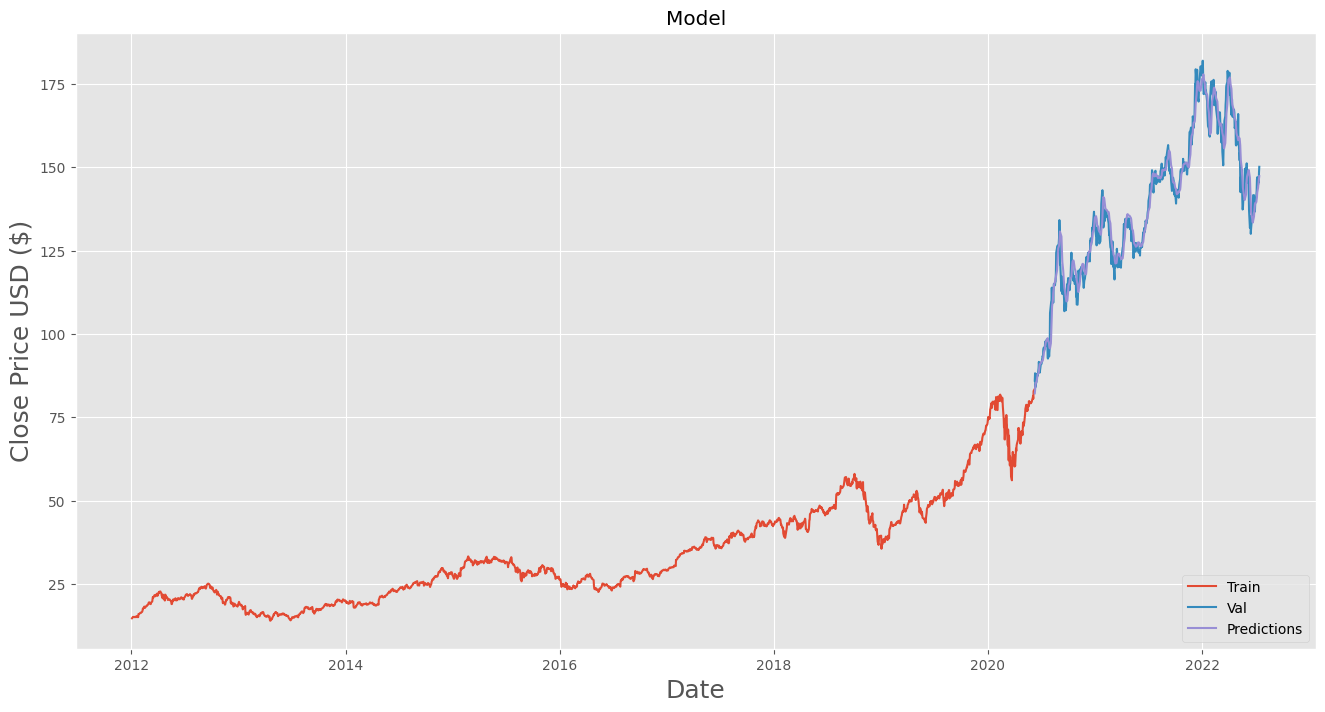

In [64]:
# plot the data
train = data[:training_data_len] # Contains data from index 0 to training_data_len
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

## Predicting the closing price for the 19th of July 2022

In [86]:
# Fetch stock data for AAPL from Yahoo Finance
apple_quote = yf.download('AAPL', start='2012-01-01', end='2022-07-20')

# Create new dataframe
new_df = apple_quote.filter(['Close'])

# Get the last 60 day closing price values and convert the dataframe to an array
last_60_days = new_df[-60:].values

# Scale the data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)

# Create an empty list
X_test = []

# Append the past 60 days
X_test.append(last_60_days_scaled)

# Convert the X_test to np array
X_test = np.array(X_test)

# Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Get the predicted scaled price
pred_price = model.predict(X_test)

# undo the scaling
pred_price = scaler.inverse_transform(pred_price)

print(pred_price) # that is the predicted price for July 19th, 2022

[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 21ms/step
[[149.5423]]


## The actual price on the 19th of July 2022

In [88]:
# Actual price 
apple_quote_2 = yf.download('AAPL', start='2012-01-01', end='2022-07-20')
apple_quote_2['Close'][-1]

[*********************100%%**********************]  1 of 1 completed


151.0